In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import torch
import cv2
import os
import random
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
from tqdm import tqdm

In [ ]:
import kagglehub

# Download latest version
celebs_path = kagglehub.dataset_download("reubensuju/celeb-df-v2")

print("Path to dataset files:", celebs_path)

In [ ]:
def extract_frames(video_path, filename, output_folder):
        # Create output folder if it doesn't exist
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Open the video file
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Error: Could not open video file {video_path}")
            return

        frame_count = 0
        while True:
            # Read a frame
            ret, frame = cap.read()

            # If frame is not read successfully, break the loop
            if not ret:
                break

            # Save the frame
            frame_filename = os.path.join(output_folder, f"frame_{frame_count:05d}_{filename}.jpg")
            cv2.imwrite(frame_filename, frame)

            frame_count += 1

        # Release the video capture object
        cap.release()
        print(f"Extracted {frame_count} frames to {output_folder}")

In [ ]:
with open(os.path.join(celebs_path, 'List_of_testing_videos.txt')) as f:
    lines = f.read().strip().split("\n")
    for line in lines:
        label_video = line.split(" ")
        label = label_video[0]
        video = label_video[1]
        video_path = os.path.join(celebs_path, video)
        output_path = os.path.join("frames", label)
        extract_frames(video_path, video[:-4].replace("/", "_"), output_path) 

In [ ]:
#each image will be 64x64
image_size = 64

celebs_image_dataset = ImageFolder(root="frames",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [ ]:
features_extract = []
labels_extract = []
for i in tqdm(range(len(celebs_image_dataset))):
    t = celebs_image_dataset[i]
    features_extract.append(t[0])
    labels_extract.append(t[1])

X_unshuffled = torch.stack(features_extract, dim = 0)
y_unshuffled = torch.Tensor(labels_extract).type(torch.LongTensor)

#convention: real = 0, fake = 1
real_mask = y_unshuffled == 1
fake_mask = y_unshuffled == 0

y_unshuffled[real_mask] = 0
y_unshuffled[fake_mask] = 1


random.seed(0)
shuffle_mask = np.arange(0, len(X_unshuffled), 1)
random.shuffle(shuffle_mask)

X_shuffled = X_unshuffled[shuffle_mask]
y_shuffled = y_unshuffled[shuffle_mask]

In [ ]:
n_real = 25000
n_fake = 25000

real_indices = torch.argwhere(y_shuffled == 0).T.squeeze()
fake_indices = torch.argwhere(y_shuffled == 1).T.squeeze()

sample_indices = torch.cat([real_indices[:n_real], fake_indices[:n_fake]], dim=0)

torch.save(X_shuffled[sample_indices], "X_celebs_df_2.pt")
torch.save(y_shuffled[sample_indices], "y_celebs_df_2.pt")
print("Feature size:", X_shuffled.shape)
print("Label size:", y_shuffled.shape)

# Res

In [2]:
X_sample = torch.load("X_celebs_df_2.pt")
y_sample = torch.load("y_celebs_df_2.pt")

random.seed(0)
shuffle_mask = np.arange(0, len(X_sample), 1)
random.shuffle(shuffle_mask)

X_sample = X_sample[shuffle_mask]
y_sample = y_sample[shuffle_mask]

print(X_sample.shape)
print(y_sample.shape)

torch.Size([50000, 3, 64, 64])
torch.Size([50000])


In [ ]:
labels, sizes = np.unique(y_sample, return_counts=True)
plt.pie(sizes, labels=["fake", "real"], autopct='%1.1f%%')
plt.title("Class distribution for celebs_df_v2")
plt.show()

In [ ]:
fake_mask = y_sample == 1
fake_imgs = X_sample[fake_mask]
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_imgs[:64], padding=2, normalize=True),(1,2,0)))
plt.show()

In [ ]:
real_mask = y_sample == 0
real_imgs = X_sample[real_mask]
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_imgs[:64], padding=2, normalize=True),(1,2,0)))
plt.show()

In [3]:
class ResNetClassifier:

    def __init__(self, resnet_model: nn.Module = None, k:int=2, lr:float=1e-3, epochs: int=10, batch_size: int=64, 
                 optimizer_func: torch.optim.Optimizer = torch.optim.Adam):
        
        assert resnet_model is not None
        self.model = nn.Sequential(resnet_model, nn.Linear(1000, k), nn.Softmax(dim=1))
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer_func = optimizer_func


    def eval(self, train_X: torch.Tensor, train_y: torch.Tensor, test_X: torch.Tensor, test_y: torch.Tensor):
        self.model.eval()
        train_pred_y = self.predict(train_X)
        test_pred_y = self.predict(test_X)

        acc_train = accuracy_score(train_y, train_pred_y)
        acc_test = accuracy_score(test_y, test_pred_y)

        criterion = nn.CrossEntropyLoss()
        loss_train = criterion(self.model(train_X), train_y).detach()
        loss_test =  criterion(self.model(test_X), test_y).detach()

        return acc_train, acc_test, loss_train, loss_test


    def fit(self, X: torch.Tensor, y: torch.Tensor):

        criterion = nn.CrossEntropyLoss()
        optimizer = self.optimizer_func(self.model.parameters(), self.lr)

        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size= 0.2)
        train_tensor = TensorDataset(train_X, train_y)
        train_loader = DataLoader(train_tensor, batch_size=self.batch_size, shuffle=True)

        self.train_losses = []
        self.test_losses = []
        self.train_acces = []
        self.test_acces = []
        for i in range(self.epochs):
            self.model.train()

            for batch in train_loader:
                #extract features (X) and labels (y)
                X_tensor, y_tensor = batch 

                #extract the hypothesis for X (the probabilities according to our model)
                h_X = self.model(X_tensor)   

                #compute cross entropy loss
                loss = criterion(h_X, y_tensor)

                #update the model's parameters using gradient ascent and backpropagation
                loss.backward() 
                optimizer.step() 
                optimizer.zero_grad() 

                acc_train, acc_test, loss_train, loss_test = self.eval(train_X, train_y, test_X, test_y)

                self.train_losses.append(loss_train)
                self.test_losses.append(loss_test)
                self.train_acces.append(acc_train)
                self.test_acces.append(acc_test)

            print("Epoch {} Complete: Train Loss = {}, Test Loss = {}, Train Accuracy = {}%, Test Accuracy = {}%".format(i, loss_train, loss_test, acc_train*100, acc_test*100))

    def plot_results(self):
        n_epochs = len(self.train_losses)
        epochs = np.arange(n_epochs)
        plt.plot(epochs, self.train_losses, label="Train Loss", c='r')
        plt.plot(epochs, self.test_losses, label="Test Loss", c='b')
        plt.xlabel("Mini Epochs")
        plt.ylabel("Binary Cross Entropy Loss")
        plt.legend()
        plt.show()

        plt.plot(epochs, self.train_acces, label="Train Accuracy", c='r')
        plt.plot(epochs, self.test_acces, label="Test Accuracy", c='b')
        plt.xlabel("Mini Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
     
    
    def predict(self, X):
        self.model.eval()
        #extract the hypothesis for X (the probabilities according to our model)
        h_X = self.model(X)
        #give a prediction based on which class probability is higher
        _, preds = torch.max(h_X, dim=1)
        return preds.detach()

            
            
        
        

Epoch 0 Complete: Train Loss = 0.6832253336906433, Test Loss = 0.6903350353240967, Train Accuracy = 57.125%, Test Accuracy = 51.0%
Epoch 1 Complete: Train Loss = 0.6625486016273499, Test Loss = 0.6906468868255615, Train Accuracy = 61.375%, Test Accuracy = 56.49999999999999%
Epoch 2 Complete: Train Loss = 0.6444165706634521, Test Loss = 0.6833621263504028, Train Accuracy = 60.62499999999999%, Test Accuracy = 52.5%
Epoch 3 Complete: Train Loss = 0.5225310325622559, Test Loss = 0.5829797387123108, Train Accuracy = 78.125%, Test Accuracy = 72.5%
Epoch 4 Complete: Train Loss = 0.5195185542106628, Test Loss = 0.61623215675354, Train Accuracy = 78.375%, Test Accuracy = 68.0%
Epoch 5 Complete: Train Loss = 0.521353006362915, Test Loss = 0.6095979809761047, Train Accuracy = 78.75%, Test Accuracy = 69.5%
Epoch 6 Complete: Train Loss = 0.45369282364845276, Test Loss = 0.5868725180625916, Train Accuracy = 85.5%, Test Accuracy = 72.0%
Epoch 7 Complete: Train Loss = 0.460209459066391, Test Loss = 0.

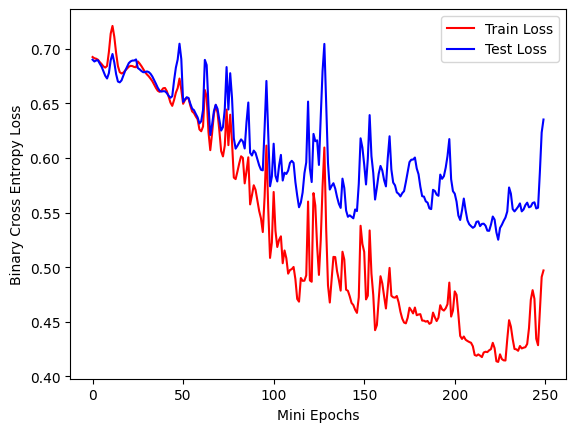

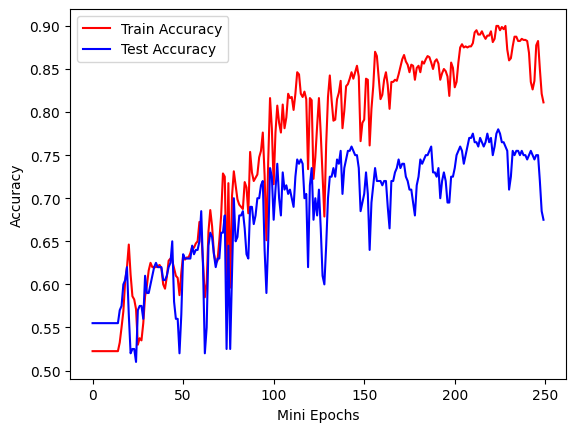

In [5]:
resnet18 = models.resnet18(weights=None) 
resnet18_deepfake_classifier = ResNetClassifier(resnet_model=resnet18, lr=1e-4, epochs = 10, batch_size=32)

resnet18_deepfake_classifier.fit(X_sample[:1000], y_sample[:1000])

resnet18_deepfake_classifier.plot_results()

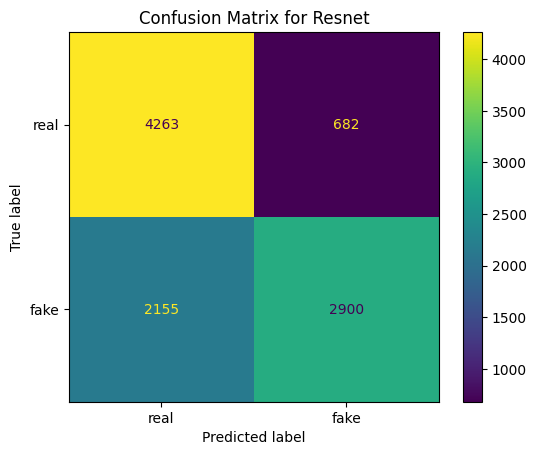

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_sample[:10000], resnet18_deepfake_classifier.predict(X_sample[:10000])), display_labels=["real", "fake"])
disp.plot()
plt.title("Confusion Matrix for Resnet")
plt.show()

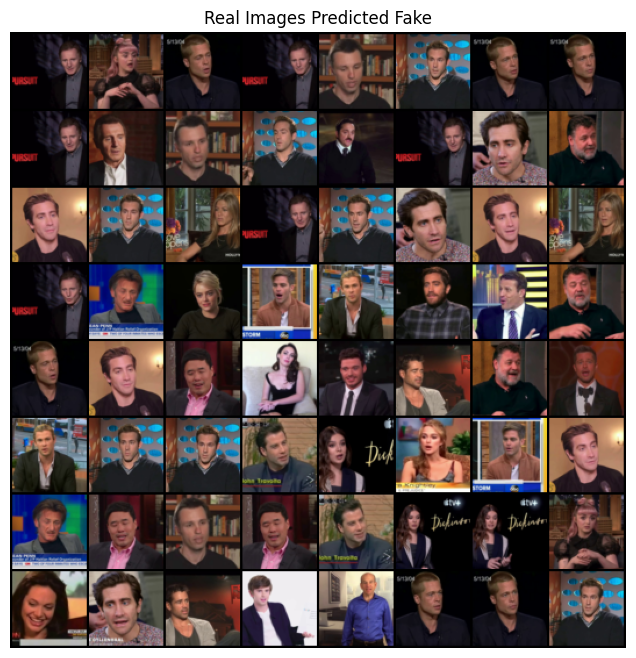

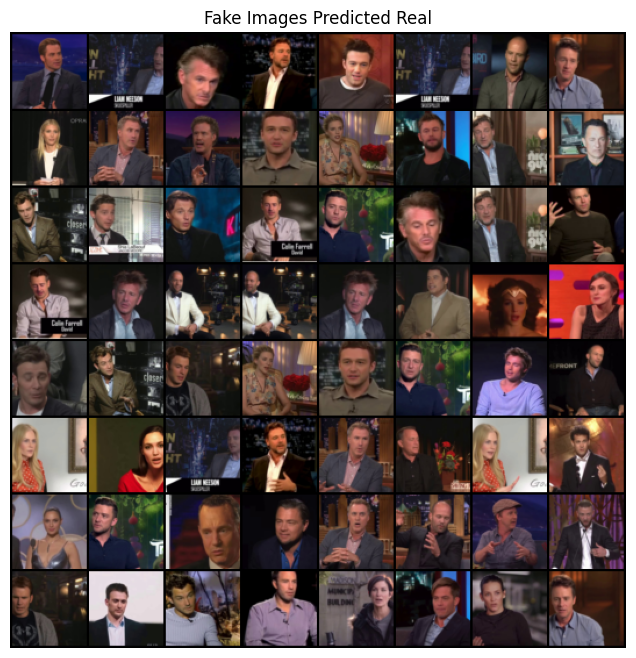

In [14]:
y_true = y_sample[:10000]
y_pred = resnet18_deepfake_classifier.predict(X_sample[:10000])

real_predicted_fake_mask = (y_true == 0) & (y_pred == 1)

fake_predicted_real_mask = (y_true == 1) & (y_pred == 0)

real_predicted_fake = X_sample[:10000][real_predicted_fake_mask]
fake_predicted_real = X_sample[:10000][fake_predicted_real_mask]

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images Predicted Fake")
plt.imshow(np.transpose(vutils.make_grid(real_predicted_fake[:64], padding=2, normalize=True),(1,2,0)))
plt.show()

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images Predicted Real")
plt.imshow(np.transpose(vutils.make_grid(fake_predicted_real[:64], padding=2, normalize=True),(1,2,0)))
plt.show()